In [11]:
include("src/model.jl")

Main.CESModel

## Loading in Data

In [12]:
data = CESModel.read_data("I-O_DE2019_formatiert.csv")

Main.CESModel.CESData(84×87 DataFrame
 Row │ Sektoren                           Erz. d. Landwirtschaft, Jagd und Die ⋯
     │ String                             Int64                                ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Erz. d. Landwirtschaft, Jagd und…                                       ⋯
   2 │ Forstwirtschaftl. Erzeugnisse un…
   3 │ Fische, Fischerei- und Aquakultu…
   4 │ Kohle
   5 │ Erdöl und Erdgas                                                        ⋯
   6 │ Erze, Steine und Erden, sonstige…
   7 │ Nahrungs- u. Futtermittel, Geträ…
   8 │ Textilien, Bekleidung, Leder und…
  ⋮  │                 ⋮                                          ⋮            ⋱
  78 │ Bruttolöhne und -gehälter                                               ⋯
  79 │ Sonst.Produktionsabgaben abzgl. …
  80 │ Abschreibungen
  81 │ Nettobetriebsüberschuss
  82 │ Bruttowertschöpfung                                                     ⋯
  

## Setting Elasticities

Es können verschiedene Elastizitäten gesetzt werden, die hier verwendeten sind übernommen aus B&F 2019 
(el. of substitiution of inermediates = 0.0001, el labor/intermediates  = 0.5 el. of consumption = 0.9)

In [13]:
elasticities = CESModel.Elasticities(0.0001, 0.5, 0.9)

Main.CESModel.Elasticities(0.0001, 0.5, 0.9)

## Setting Shocks

Shocks können entweder mit `calculate_investment!` in  1000€ eingegeben werden, oder die einzelnen Elemente im Vektor können auch direkt verändernt werden (z.b `supply_shock[12] = 1.2`), was dann einem Anstieg an demand von 20% entsrpicht.

In [14]:
deman_shock = ones(71)
supply_shock = ones(71)
shocks = CESModel.Shocks(supply_shock,deman_shock) 
#shocks.demand_shock[35] = 1.09
CESModel.calculate_investment!(shocks,data,25000,"Vorb.Baustellen-,Bauinstallations-,Ausbauarbeiten")

1.2048978788971576

## Full labor reallocation

In [15]:
price,quantity = CESModel.solve_ces_model(data,shocks,elasticities)

([0.9414662771283979, 0.6855770600909864, 0.6244054586459459, 0.7988094318208029, 0.7256080001106296, 0.7980692412591355, 0.9413472751142221, 0.8399371285656831, 0.7209376231454443, 0.90652307985496  …  0.9374540563116723, 0.936546135463671, 0.9396953689492518, 0.9447017210433883, 0.9573774851060063, 0.9384808316651674, 0.9357786376989145, 0.9267620543014236, 0.865127100350276, 0.9377494149784265], [0.017822842569161355, 0.002698048243079146, 0.00019236861163893581, 0.0010484615291857283, 0.0005707884229604307, 0.005050754335328762, 0.06459037348601993, 0.00763482332417193, 0.009157820799896372, 0.014907716432191012  …  0.08476074351186007, 0.011993745199906813, 0.0592205471991995, 0.07762445712314178, 0.03495355401150268, 0.011428410192898694, 0.009859295553372092, 0.01451722015964288, 0.0015135389093517664, 0.01793051333348333])

In [6]:
println("Real GDP: $(CESModel.real_gdp(price,quantity,data))")
println("Nominal GDP: $(CESModel.nominal_gdp(price,quantity,data))")


Real GDP: 1.0996241642069242
Nominal GDP: 0.9562693811307954


In [17]:
println("Nominal increase: $(sum(CESModel.nominal_increase(quantity,data)))")
println("Gross increase: $(sum(CESModel.gross_incease(price,quantity,data)))")

Nominal increase: 4748.898194533263
Gross increase: 28328.780881344053


## No labor reallocation 

Es können verschiedene Funktionen angegeben werden,die zurückgeben wie viel Arbeit in den einzelnen Sektoren verfügbar. Hier in diesem Fall, ist keine zusätzliche Arbeit verfügbar, die funktion könnte aber auch zum Beispiel so aussehen: 
```julia
labor_realloc(data) = min(1.05 * data.labor_share,inv(I - diagm(1 .- data.factor_share) * data.Ω) * (data.consumption_share_gross_output .* ((data.shocks.demand_shock .* data.labor_share) - data.labor_share)) + data.labor_share)
``` 
(maximal 5% der verfügbaren Arbeit kann zusätzlich verwendet werden um der gesteigerten Nachfrage nachzukommen)

In [7]:
labor_realloc(data) = data.labor_share #no labor_reallocation

labor_realloc (generic function with 1 method)

In [8]:
price,quantity = CESModel.solve_ces_model(data,shocks,elasticities,labor_reallocation = labor_realloc)

([0.921147632683455, 0.9270650861003054, 0.9214515885955984, 0.9247787486591621, 0.9207069808903534, 0.927935140771916, 0.9217875982036665, 0.9206552309309203, 0.9440167203450254, 0.9217529350560099  …  0.9254894852218095, 0.924072405321481, 0.9219802359949314, 0.9208790433587618, 0.9225067669391435, 0.9227726066407055, 0.9213228347327255, 0.9240239327822368, 0.9207874619163857, 0.9205055190333035], [0.017682137674283335, 0.0022078507670756217, 0.00016202835691791502, 0.0009671103261321754, 0.00048644246496170023, 0.004662879301863719, 0.06393880795818745, 0.00743290317382111, 0.008321802442640358, 0.01457743944741506  …  0.08421263208622785, 0.011938966500094586, 0.059214649035641796, 0.07763949051050958, 0.03495355401150268, 0.011384446759056449, 0.009805254997263705, 0.014340147029542501, 0.0014341421096760916, 0.017885519107604927])

In [9]:
println("Real GDP: $(CESModel.real_gdp(price,quantity,data))")
println("Nominal GDP: $(CESModel.nominal_gdp(price,quantity,data))")

Real GDP: 1.0804534073601424
Nominal GDP: 0.9280529147110474


In [10]:
using LinearAlgebra
using Distributed, SharedArrays
shock_values = LinRange(1.0,1.8,50)
supply_shock = ones(71)

GDP_no_realloc_nominal = SharedArray(zeros(71,50))
GDP_nominal = SharedArray(zeros(71,50))

@distributed for i in 1:71
    init = Complex.([ones(71)..., data.λ...])
    for (k,shock_value) in enumerate(shock_values)
        demand_shock = ones(71)
        demand_shock[i] = shock_value
        shock = CESModel.Shocks(supply_shock,demand_shock)

        p,q = CESModel.solve_ces_model(data,shock,elasticities,init = init,labor_reallocation = labor_realloc)
        GDP_no_realloc_nominal[i,k] = CESModel.nominal_gdp(p,q,data)
        init = Complex.([p...,q...])
    end
end

@distributed for i in 1:71
    init = Complex.([ones(71)..., data.λ...])
    for (k,shock_value) in enumerate(shock_values)
        demand_shock = ones(71)
        demand_shock[i] = shock_value
        shock = CESModel.Shocks(supply_shock,demand_shock)

        p,q = CESModel.solve_ces_model(data,shock,elasticities,init = init)
        GDP_nominal[i,k] = CESModel.nominal_gdp(p,q,data)
        init = Complex.([p...,q...])
    end
end

Task (done) @0x00007fdbd5de7530

In [11]:
findmax(mapslices(row -> maximum(collect(LinRange(1,maximum(row),50)) - row),GDP,dims=2))

UndefVarError: UndefVarError: `GDP` not defined

In [12]:
using DataFrames, CSV


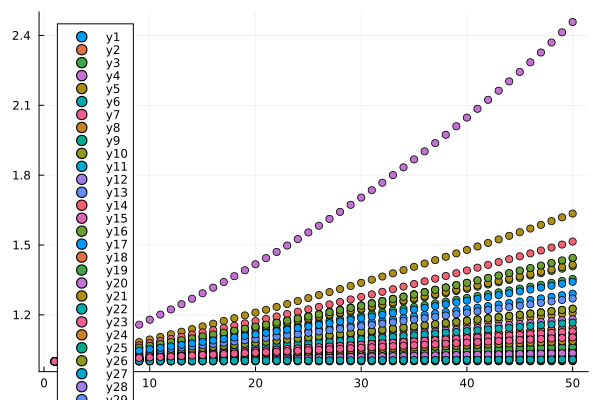

In [20]:
using Plots
scatter()
for row in eachrow(GDP_no_realloc)
    scatter!(row)
end
scatter!()

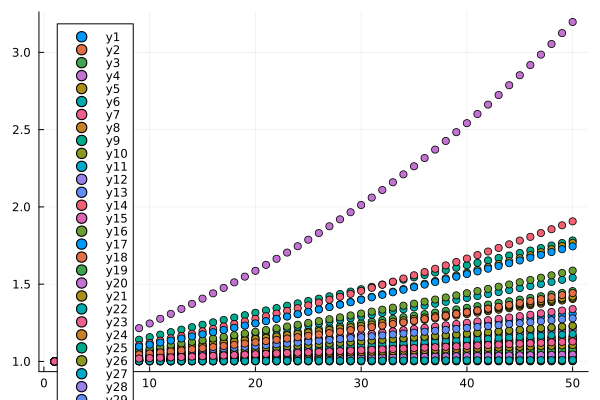

In [21]:
scatter()
for row in eachrow(GDP)
    scatter!(row)
end
scatter!()

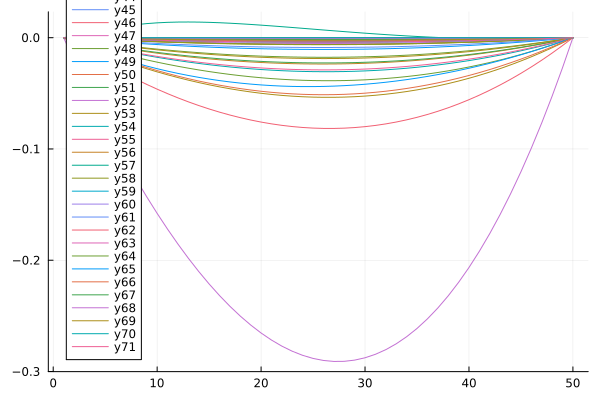

In [22]:
plot()
for row in eachrow(GDP)
    plot!(row -  LinRange(1,maximum(row),50))
end
plot!()

In [16]:
shock_values = LinRange(1.0,1.8,50)
supply_shock = ones(71)

GDP_no_realloc = SharedArray(zeros(71,50))
GDP = SharedArray(zeros(71,50))

@distributed for i in 1:71
    init = Complex.([ones(71)..., data.λ...])
    for (k,shock_value) in enumerate(shock_values)
        demand_shock = ones(71)
        demand_shock[i] = shock_value
        shock = CESModel.Shocks(supply_shock,demand_shock)

        p,q = CESModel.solve_ces_model(data,shock,elasticities,init = init,labor_reallocation = labor_realloc)
        GDP_no_realloc[i,k] = CESModel.real_gdp(p,q,data)
        init = Complex.([p...,q...])
    end
end

@distributed for i in 1:71
    init = Complex.([ones(71)..., data.λ...])
    for (k,shock_value) in enumerate(shock_values)
        demand_shock = ones(71)
        demand_shock[i] = shock_value
        shock = CESModel.Shocks(supply_shock,demand_shock)

        p,q = CESModel.solve_ces_model(data,shock,elasticities,init = init)
        GDP[i,k] = CESModel.real_gdp(p,q,data)
        init = Complex.([p...,q...])
    end
end


Task (done) @0x00007fdb0cc54010

In [17]:
function savetabular(filname,gdp)
    sectors = data.io.Sektoren[1:71]
    df = DataFrame(gdp[1:end,:]',sectors)
    df[:,:DemandShockAmount] = collect(shock_values)
    CSV.write(joinpath(pwd(),"data",filname),df)
end

savetabular (generic function with 1 method)

In [18]:
GDP_no_realloc_nominal = GDP_no_realloc_nominal[:,1:50]

71×50 Matrix{Float64}:
 1.0  0.999001  0.998002  0.997004  0.996006  …  0.953494  0.952516  0.951539
 1.0  0.999789  0.999578  0.999367  0.999155     0.989882  0.989663  0.989444
 1.0  0.999989  0.999978  0.999968  0.999957     0.999486  0.999475  0.999463
 1.0  0.999923  0.999845  0.999768  0.999691     0.996322  0.996242  0.996163
 1.0  0.999949  0.999897  0.999846  0.999795     0.997543  0.99749   0.997437
 1.0  0.999668  0.999337  0.999005  0.998673  …  0.984331  0.983996  0.983661
 1.0  0.998699  0.9974    0.996102  0.994805     0.940286  0.939048  0.93781
 1.0  0.999773  0.999546  0.999319  0.999091     0.989194  0.988961  0.988729
 1.0  0.99965   0.999299  0.998948  0.998598     0.983491  0.983139  0.982788
 1.0  0.999102  0.998204  0.997306  0.996409     0.958102  0.957219  0.956336
 ⋮                                            ⋱                      
 1.0  0.998528  0.997057  0.995586  0.994116     0.931667  0.930238  0.92881
 1.0  0.992878  0.985801  0.978768  0.97178      0.

In [19]:
savetabular("demand_shock_nominal.csv",GDP_nominal)
savetabular("demand_shock_nominal_no_realloc.csv",GDP_no_realloc_nominal)
savetabular("demand_shock.csv",GDP)
savetabular("demand_shock_no_realloc.csv",GDP_no_realloc)

"/home/franzs/Schreibtisch/BeyondHulten/data/demand_shock_no_realloc.csv"

In [10]:
CESModel.gross_incease(price,quantity,data)

MethodError: MethodError: no method matching *(::Vector{Float64}, ::Vector{Float64})

Closest candidates are:
  *(::Any, ::Any, !Matched::Any, !Matched::Any...)
   @ Base operators.jl:578
  *(!Matched::StridedMatrix{T}, ::StridedVector{S}) where {T<:Union{Float32, Float64, ComplexF32, ComplexF64}, S<:Real}
   @ LinearAlgebra /usr/share/julia/stdlib/v1.9/LinearAlgebra/src/matmul.jl:49
  *(::StridedVecOrMat, !Matched::LinearAlgebra.Adjoint{<:Any, <:LinearAlgebra.LQPackedQ})
   @ LinearAlgebra /usr/share/julia/stdlib/v1.9/LinearAlgebra/src/lq.jl:269
  ...
